## Module 3 Homework

In this homework, we're going to work with categorical variables, first ML models (Decision Trees), and hyperparameter tuning.

Please use the [Colab Module 3](https://github.com/DataTalksClub/stock-markets-analytics-zoomcamp/blob/main/03-modeling/Module_3_Colab_Time_Series_Modeling.ipynb) for all tasks to ensure you have the same dataframe used for the Modeling part, as covered during the lecture.
We suggest copying and extending it (around "TODO" comments).

### Question 1 (1 point): Dummies on Month and Week-of-Month

**Find the ABSOLUTE CORRELATION VALUE of the most correlated dummy <month-week_of_month> with the binary outcome variable `is_positive_growth_5d_future`?**

You saw in the correlation analysis and modeling that September and October may be important seasonal months. In this task, we'll go futher and try to generate dummies for Month and Week-of-month (starting from 1). For example, the first week of October should be coded similar to this: 'October_w1'.
Once you've generated the new set of variables, find the most correlated (in absolute value) one with `is_positive_growth_5d_future` and round it to 3 digits after the comma.

Suggested path to a solution:
- [[Source](https://stackoverflow.com/questions/25249033/week-of-a-month-pandas)] Use this formula to get the week of month for the datetime variable d: `(d.day-1)//7+1`
- Define a new string variable for all month-week_of_month combinations. Append it to the CATEGORICAL features set. You should have 5 variables treated as CATEGORICAL now: 'Month', 'Weekday', 'Ticker', 'ticker_type', 'month_wom'. In the end, you should get 115 dummy features, including 60 (=12*5) week_month_of_week dummies.
- Use [pandas.get_dummies()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) to generate dummies.
- Use [pandas.DataFrame.corr()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html) function (also used in [Code Snippet 1]) to get correlations with `is_positive_growth_5d_future`, filter out only variables representing the new dummy set, and sort it by absolute values (you can define a new column "abs_corr" in the dataframe with correlations), and find the highest value (among the new dummies features set).

**NOTE**: new dummies will be used as features in the next tasks, please leave them in the dataset.

In [ ]:
!pip install yfinance
!pip install pandas
!pip uninstall gdown -y && pip install gdown
!gdown -V

Found existing installation: gdown 5.1.0
Uninstalling gdown-5.1.0:
  Successfully uninstalled gdown-5.1.0
gdown 5.2.0 at /usr/local/lib/python3.10/dist-packages


In [ ]:
# IMPORTS
import numpy as np
import pandas as pd
import math

#Fin Data Sources
import yfinance as yf
import pandas_datareader as pdr

#Data viz
import plotly.graph_objs as go
import plotly.graph_objects as go
import plotly.express as px

import time
from datetime import date, datetime

# for graphs
import matplotlib.pyplot as plt

In [ ]:
# full dataset for 33 stocks
!gdown https://drive.google.com/file/d/1kNWWPi49td0EZhmi6LzNCa2ssC5IUxHP/view?usp=sharing --fuzzy -O /content/

df_full = pd.read_parquet("/content/stocks_df_combined_2024_05_07.parquet.brotli")
df_full

#/content/stocks_df_combined_2024_05_07.parquet.brotli

Downloading...
From (original): https://drive.google.com/uc?id=1kNWWPi49td0EZhmi6LzNCa2ssC5IUxHP
From (redirected): https://drive.google.com/uc?id=1kNWWPi49td0EZhmi6LzNCa2ssC5IUxHP&confirm=t&uuid=5d14025f-5df6-4f99-9111-221b8638170e
To: /content/stocks_df_combined_2024_05_07.parquet.brotli
100% 119M/119M [00:00<00:00, 121MB/s] 


,Open,High,Low,Close,Adj Close_x,Volume,Ticker,Year,Month,Weekday,...,growth_brent_oil_7d,growth_brent_oil_30d,growth_brent_oil_90d,growth_brent_oil_365d,growth_btc_usd_1d,growth_btc_usd_3d,growth_btc_usd_7d,growth_btc_usd_30d,growth_btc_usd_90d,growth_btc_usd_365d
0,0.088542,0.101563,0.088542,0.097222,0.060163,1.031789e+09,MSFT,1986,1986-03-01,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.097222,0.102431,0.097222,0.100694,0.062311,3.081600e+08,MSFT,1986,1986-03-01,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.100694,0.103299,0.100694,0.102431,0.063386,1.331712e+08,MSFT,1986,1986-03-01,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.102431,0.103299,0.098958,0.099826,0.061774,6.776640e+07,MSFT,1986,1986-03-01,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.099826,0.100694,0.097222,0.098090,0.060700,4.789440e+07,MSFT,1986,1986-03-01,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5422,3639.000000,3648.949951,3584.050049,3594.300049,3594.300049,1.571996e+06,LT.NS,2024,2024-04-01,1,...,1.006530,1.011164,1.108923,0.936075,0.949809,0.956129,0.913106,0.850046,1.423982,2.158543
5423,3590.050049,3634.149902,3576.050049,3599.500000,3599.500000,3.748847e+06,LT.NS,2024,2024-05-01,3,...,0.946279,0.973473,1.053911,0.931945,1.014925,0.926103,0.916902,0.903379,1.369046,2.038296
5424,3610.000000,3622.000000,3488.449951,3499.800049,3499.800049,4.079696e+06,LT.NS,2024,2024-05-01,4,...,0.942513,0.967125,1.049197,0.946816,1.063704,1.037155,0.986425,0.953153,1.462818,2.180063
5425,3522.800049,3527.000000,3441.100098,3463.300049,3463.300049,2.614667e+06,LT.NS,2024,2024-05-01,0,...,0.936187,0.975418,1.027877,0.952887,0.986426,1.004327,0.989362,0.916771,1.465996,2.219715


In [ ]:
# growth indicators (but not future growth)
GROWTH = [g for g in df_full.keys() if (g.find('growth_')==0)&(g.find('future')<0)]
GROWTH

['growth_1d',
 'growth_3d',
 'growth_7d',
 'growth_30d',
 'growth_90d',
 'growth_365d',
 'growth_dax_1d',
 'growth_dax_3d',
 'growth_dax_7d',
 'growth_dax_30d',
 'growth_dax_90d',
 'growth_dax_365d',
 'growth_snp500_1d',
 'growth_snp500_3d',
 'growth_snp500_7d',
 'growth_snp500_30d',
 'growth_snp500_90d',
 'growth_snp500_365d',
 'growth_dji_1d',
 'growth_dji_3d',
 'growth_dji_7d',
 'growth_dji_30d',
 'growth_dji_90d',
 'growth_dji_365d',
 'growth_epi_1d',
 'growth_epi_3d',
 'growth_epi_7d',
 'growth_epi_30d',
 'growth_epi_90d',
 'growth_epi_365d',
 'growth_gold_1d',
 'growth_gold_3d',
 'growth_gold_7d',
 'growth_gold_30d',
 'growth_gold_90d',
 'growth_gold_365d',
 'growth_wti_oil_1d',
 'growth_wti_oil_3d',
 'growth_wti_oil_7d',
 'growth_wti_oil_30d',
 'growth_wti_oil_90d',
 'growth_wti_oil_365d',
 'growth_brent_oil_1d',
 'growth_brent_oil_3d',
 'growth_brent_oil_7d',
 'growth_brent_oil_30d',
 'growth_brent_oil_90d',
 'growth_brent_oil_365d',
 'growth_btc_usd_1d',
 'growth_btc_usd_3d',


In [ ]:
OHLCV = ['Open','High','Low','Close','Adj Close_x','Volume']
CATEGORICAL = ['Month', 'Weekday', 'Ticker', 'ticker_type']
TO_PREDICT = [g for g in df_full.keys() if (g.find('future')>=0)]
TO_DROP = ['Year','Date','index_x', 'index_y', 'index', 'Quarter','Adj Close_y'] + CATEGORICAL + OHLCV
# manually defined features
CUSTOM_NUMERICAL = ['SMA10', 'SMA20', 'growing_moving_average', 'high_minus_low_relative','volatility', 'ln_volume']
TECHNICAL_INDICATORS = ['adx', 'adxr', 'apo', 'aroon_1','aroon_2', 'aroonosc',
 'bop', 'cci', 'cmo','dx', 'macd', 'macdsignal', 'macdhist', 'macd_ext',
 'macdsignal_ext', 'macdhist_ext', 'macd_fix', 'macdsignal_fix',
 'macdhist_fix', 'mfi', 'minus_di', 'mom', 'plus_di', 'dm', 'ppo',
 'roc', 'rocp', 'rocr', 'rocr100', 'rsi', 'slowk', 'slowd', 'fastk',
 'fastd', 'fastk_rsi', 'fastd_rsi', 'trix', 'ultosc', 'willr',
 'ad', 'adosc', 'obv', 'atr', 'natr', 'ht_dcperiod', 'ht_dcphase',
 'ht_phasor_inphase', 'ht_phasor_quadrature', 'ht_sine_sine', 'ht_sine_leadsine',
 'ht_trendmod', 'avgprice', 'medprice', 'typprice', 'wclprice']
TECHNICAL_PATTERNS = [g for g in df_full.keys() if g.find('cdl')>=0]
MACRO = ['gdppot_us_yoy', 'gdppot_us_qoq', 'cpi_core_yoy', 'cpi_core_mom', 'FEDFUNDS',
 'DGS1', 'DGS5', 'DGS10']
NUMERICAL = GROWTH + TECHNICAL_INDICATORS + TECHNICAL_PATTERNS + CUSTOM_NUMERICAL + MACRO
OTHER = [k for k in df_full.keys() if k not in OHLCV + CATEGORICAL + NUMERICAL + TO_DROP]
print(f'Technical patterns count = {len(TECHNICAL_PATTERNS)}, examples = {TECHNICAL_PATTERNS[0:5]}')




Technical patterns count = 61, examples = ['cdl2crows', 'cdl3blackrows', 'cdl3inside', 'cdl3linestrike', 'cdl3outside']


In [ ]:
TO_PREDICT.pop(0)
TO_PREDICT

['is_positive_growth_5d_future']

In [ ]:
# tickers, min-max date, count of daily observations
df_full.groupby(['Ticker'])['Date'].agg(['min','max','count'])

,min,max,count
Ticker,,,
AAPL,1980-12-12,2024-05-07,10941
ACN,2001-07-19,2024-05-07,5736
AMZN,1997-05-15,2024-05-07,6789
ASML,1995-03-15,2024-05-07,7338
AVGO,2009-08-06,2024-05-07,3713
BHARTIARTL.NS,2002-07-01,2024-05-07,5424
BRK-B,1996-05-09,2024-05-07,7046
CDI.PA,1992-01-27,2024-05-07,8328
GOOG,2004-08-19,2024-05-07,4963


In [ ]:
# let's define on more custom numerical features
df_full['ln_volume'] = df_full.Volume.apply(lambda x: np.log(x))
df_full

,Open,High,Low,Close,Adj Close_x,Volume,Ticker,Year,Month,Weekday,...,growth_brent_oil_30d,growth_brent_oil_90d,growth_brent_oil_365d,growth_btc_usd_1d,growth_btc_usd_3d,growth_btc_usd_7d,growth_btc_usd_30d,growth_btc_usd_90d,growth_btc_usd_365d,ln_volume
0,0.088542,0.101563,0.088542,0.097222,0.060163,1.031789e+09,MSFT,1986,1986-03-01,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.754560
1,0.097222,0.102431,0.097222,0.100694,0.062311,3.081600e+08,MSFT,1986,1986-03-01,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.546130
2,0.100694,0.103299,0.100694,0.102431,0.063386,1.331712e+08,MSFT,1986,1986-03-01,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.707146
3,0.102431,0.103299,0.098958,0.099826,0.061774,6.776640e+07,MSFT,1986,1986-03-01,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.031577
4,0.099826,0.100694,0.097222,0.098090,0.060700,4.789440e+07,MSFT,1986,1986-03-01,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.684509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5422,3639.000000,3648.949951,3584.050049,3594.300049,3594.300049,1.571996e+06,LT.NS,2024,2024-04-01,1,...,1.011164,1.108923,0.936075,0.949809,0.956129,0.913106,0.850046,1.423982,2.158543,14.267857
5423,3590.050049,3634.149902,3576.050049,3599.500000,3599.500000,3.748847e+06,LT.NS,2024,2024-05-01,3,...,0.973473,1.053911,0.931945,1.014925,0.926103,0.916902,0.903379,1.369046,2.038296,15.136959
5424,3610.000000,3622.000000,3488.449951,3499.800049,3499.800049,4.079696e+06,LT.NS,2024,2024-05-01,4,...,0.967125,1.049197,0.946816,1.063704,1.037155,0.986425,0.953153,1.462818,2.180063,15.221533
5425,3522.800049,3527.000000,3441.100098,3463.300049,3463.300049,2.614667e+06,LT.NS,2024,2024-05-01,0,...,0.975418,1.027877,0.952887,0.986426,1.004327,0.989362,0.916771,1.465996,2.219715,14.776647


In [ ]:
# truncated df_full with 25 years of data (and defined growth variables)
#df = df_full[df_full.Date>='2000-01-01']
df = df_full

In [ ]:

df['Month_name'] = df['Month'].dt.month_name()
df

,Open,High,Low,Close,Adj Close_x,Volume,Ticker,Year,Month,Weekday,...,growth_brent_oil_90d,growth_brent_oil_365d,growth_btc_usd_1d,growth_btc_usd_3d,growth_btc_usd_7d,growth_btc_usd_30d,growth_btc_usd_90d,growth_btc_usd_365d,ln_volume,Month_name
0,0.088542,0.101563,0.088542,0.097222,0.060163,1.031789e+09,MSFT,1986,1986-03-01,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.754560,March
1,0.097222,0.102431,0.097222,0.100694,0.062311,3.081600e+08,MSFT,1986,1986-03-01,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.546130,March
2,0.100694,0.103299,0.100694,0.102431,0.063386,1.331712e+08,MSFT,1986,1986-03-01,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.707146,March
3,0.102431,0.103299,0.098958,0.099826,0.061774,6.776640e+07,MSFT,1986,1986-03-01,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.031577,March
4,0.099826,0.100694,0.097222,0.098090,0.060700,4.789440e+07,MSFT,1986,1986-03-01,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.684509,March
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5422,3639.000000,3648.949951,3584.050049,3594.300049,3594.300049,1.571996e+06,LT.NS,2024,2024-04-01,1,...,1.108923,0.936075,0.949809,0.956129,0.913106,0.850046,1.423982,2.158543,14.267857,April
5423,3590.050049,3634.149902,3576.050049,3599.500000,3599.500000,3.748847e+06,LT.NS,2024,2024-05-01,3,...,1.053911,0.931945,1.014925,0.926103,0.916902,0.903379,1.369046,2.038296,15.136959,May
5424,3610.000000,3622.000000,3488.449951,3499.800049,3499.800049,4.079696e+06,LT.NS,2024,2024-05-01,4,...,1.049197,0.946816,1.063704,1.037155,0.986425,0.953153,1.462818,2.180063,15.221533,May
5425,3522.800049,3527.000000,3441.100098,3463.300049,3463.300049,2.614667e+06,LT.NS,2024,2024-05-01,0,...,1.027877,0.952887,0.986426,1.004327,0.989362,0.916771,1.465996,2.219715,14.776647,May


In [ ]:
import numpy as np

def week_of_month(x):
    first_day = x.replace(day=1)
    dom = x.day
    adjusted_dom = dom + first_day.weekday()
    return int(np.ceil(adjusted_dom/7.0))
df["Week_of_month"] = df["Month"].apply(week_of_month)
df

,Open,High,Low,Close,Adj Close_x,Volume,Ticker,Year,Month,Weekday,...,growth_brent_oil_365d,growth_btc_usd_1d,growth_btc_usd_3d,growth_btc_usd_7d,growth_btc_usd_30d,growth_btc_usd_90d,growth_btc_usd_365d,ln_volume,Month_name,Week_of_month
0,0.088542,0.101563,0.088542,0.097222,0.060163,1.031789e+09,MSFT,1986,1986-03-01,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.754560,March,1
1,0.097222,0.102431,0.097222,0.100694,0.062311,3.081600e+08,MSFT,1986,1986-03-01,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.546130,March,1
2,0.100694,0.103299,0.100694,0.102431,0.063386,1.331712e+08,MSFT,1986,1986-03-01,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.707146,March,1
3,0.102431,0.103299,0.098958,0.099826,0.061774,6.776640e+07,MSFT,1986,1986-03-01,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.031577,March,1
4,0.099826,0.100694,0.097222,0.098090,0.060700,4.789440e+07,MSFT,1986,1986-03-01,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.684509,March,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5422,3639.000000,3648.949951,3584.050049,3594.300049,3594.300049,1.571996e+06,LT.NS,2024,2024-04-01,1,...,0.936075,0.949809,0.956129,0.913106,0.850046,1.423982,2.158543,14.267857,April,1
5423,3590.050049,3634.149902,3576.050049,3599.500000,3599.500000,3.748847e+06,LT.NS,2024,2024-05-01,3,...,0.931945,1.014925,0.926103,0.916902,0.903379,1.369046,2.038296,15.136959,May,1
5424,3610.000000,3622.000000,3488.449951,3499.800049,3499.800049,4.079696e+06,LT.NS,2024,2024-05-01,4,...,0.946816,1.063704,1.037155,0.986425,0.953153,1.462818,2.180063,15.221533,May,1
5425,3522.800049,3527.000000,3441.100098,3463.300049,3463.300049,2.614667e+06,LT.NS,2024,2024-05-01,0,...,0.952887,0.986426,1.004327,0.989362,0.916771,1.465996,2.219715,14.776647,May,1


In [ ]:
df["month_wom"] = df["Month_name"] + "_w" + df["Week_of_month"].astype('str')
df

,Open,High,Low,Close,Adj Close_x,Volume,Ticker,Year,Month,Weekday,...,growth_btc_usd_1d,growth_btc_usd_3d,growth_btc_usd_7d,growth_btc_usd_30d,growth_btc_usd_90d,growth_btc_usd_365d,ln_volume,Month_name,Week_of_month,month_wom
0,0.088542,0.101563,0.088542,0.097222,0.060163,1.031789e+09,MSFT,1986,1986-03-01,3,...,NaN,NaN,NaN,NaN,NaN,NaN,20.754560,March,1,March_w1
1,0.097222,0.102431,0.097222,0.100694,0.062311,3.081600e+08,MSFT,1986,1986-03-01,4,...,NaN,NaN,NaN,NaN,NaN,NaN,19.546130,March,1,March_w1
2,0.100694,0.103299,0.100694,0.102431,0.063386,1.331712e+08,MSFT,1986,1986-03-01,0,...,NaN,NaN,NaN,NaN,NaN,NaN,18.707146,March,1,March_w1
3,0.102431,0.103299,0.098958,0.099826,0.061774,6.776640e+07,MSFT,1986,1986-03-01,1,...,NaN,NaN,NaN,NaN,NaN,NaN,18.031577,March,1,March_w1
4,0.099826,0.100694,0.097222,0.098090,0.060700,4.789440e+07,MSFT,1986,1986-03-01,2,...,NaN,NaN,NaN,NaN,NaN,NaN,17.684509,March,1,March_w1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5422,3639.000000,3648.949951,3584.050049,3594.300049,3594.300049,1.571996e+06,LT.NS,2024,2024-04-01,1,...,0.949809,0.956129,0.913106,0.850046,1.423982,2.158543,14.267857,April,1,April_w1
5423,3590.050049,3634.149902,3576.050049,3599.500000,3599.500000,3.748847e+06,LT.NS,2024,2024-05-01,3,...,1.014925,0.926103,0.916902,0.903379,1.369046,2.038296,15.136959,May,1,May_w1
5424,3610.000000,3622.000000,3488.449951,3499.800049,3499.800049,4.079696e+06,LT.NS,2024,2024-05-01,4,...,1.063704,1.037155,0.986425,0.953153,1.462818,2.180063,15.221533,May,1,May_w1
5425,3522.800049,3527.000000,3441.100098,3463.300049,3463.300049,2.614667e+06,LT.NS,2024,2024-05-01,0,...,0.986426,1.004327,0.989362,0.916771,1.465996,2.219715,14.776647,May,1,May_w1


In [ ]:
df["month_weekday"] = df["Month_name"] + "_d" + df["Weekday"].astype('str')

In [ ]:
new_entrants = ["month_wom"]
CATEGORICAL = ['Month', 'Weekday', 'Ticker', 'ticker_type']
CATEGORICAL.extend(new_entrants)
CATEGORICAL


['Month', 'Weekday', 'Ticker', 'ticker_type', 'month_wom']

In [ ]:
df

,Open,High,Low,Close,Adj Close_x,Volume,Ticker,Year,Month,Weekday,...,growth_btc_usd_3d,growth_btc_usd_7d,growth_btc_usd_30d,growth_btc_usd_90d,growth_btc_usd_365d,ln_volume,Month_name,Week_of_month,month_wom,month_weekday
0,0.088542,0.101563,0.088542,0.097222,0.060163,1.031789e+09,MSFT,1986,1986-03-01,3,...,NaN,NaN,NaN,NaN,NaN,20.754560,March,1,March_w1,March_d3
1,0.097222,0.102431,0.097222,0.100694,0.062311,3.081600e+08,MSFT,1986,1986-03-01,4,...,NaN,NaN,NaN,NaN,NaN,19.546130,March,1,March_w1,March_d4
2,0.100694,0.103299,0.100694,0.102431,0.063386,1.331712e+08,MSFT,1986,1986-03-01,0,...,NaN,NaN,NaN,NaN,NaN,18.707146,March,1,March_w1,March_d0
3,0.102431,0.103299,0.098958,0.099826,0.061774,6.776640e+07,MSFT,1986,1986-03-01,1,...,NaN,NaN,NaN,NaN,NaN,18.031577,March,1,March_w1,March_d1
4,0.099826,0.100694,0.097222,0.098090,0.060700,4.789440e+07,MSFT,1986,1986-03-01,2,...,NaN,NaN,NaN,NaN,NaN,17.684509,March,1,March_w1,March_d2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5422,3639.000000,3648.949951,3584.050049,3594.300049,3594.300049,1.571996e+06,LT.NS,2024,2024-04-01,1,...,0.956129,0.913106,0.850046,1.423982,2.158543,14.267857,April,1,April_w1,April_d1
5423,3590.050049,3634.149902,3576.050049,3599.500000,3599.500000,3.748847e+06,LT.NS,2024,2024-05-01,3,...,0.926103,0.916902,0.903379,1.369046,2.038296,15.136959,May,1,May_w1,May_d3
5424,3610.000000,3622.000000,3488.449951,3499.800049,3499.800049,4.079696e+06,LT.NS,2024,2024-05-01,4,...,1.037155,0.986425,0.953153,1.462818,2.180063,15.221533,May,1,May_w1,May_d4
5425,3522.800049,3527.000000,3441.100098,3463.300049,3463.300049,2.614667e+06,LT.NS,2024,2024-05-01,0,...,1.004327,0.989362,0.916771,1.465996,2.219715,14.776647,May,1,May_w1,May_d0


In [ ]:
df.loc[:,'Month'] = df.Month.dt.strftime('%B')
df.loc[:,'Weekday'] = df.Weekday.astype(str)

In [ ]:
df[CATEGORICAL]


,Month,Weekday,Ticker,ticker_type,month_wom
0,March,3,MSFT,US,March_w1
1,March,4,MSFT,US,March_w1
2,March,0,MSFT,US,March_w1
3,March,1,MSFT,US,March_w1
4,March,2,MSFT,US,March_w1
...,...,...,...,...,...
5422,April,1,LT.NS,INDIA,April_w1
5423,May,3,LT.NS,INDIA,May_w1
5424,May,4,LT.NS,INDIA,May_w1
5425,May,0,LT.NS,INDIA,May_w1


In [ ]:
dummy_variables = pd.get_dummies(df[CATEGORICAL], dtype='int32')
dummy_variables
predict_df = pd.get_dummies(df[TO_PREDICT], dtype='float')
predict_df

,is_positive_growth_5d_future
0,0
1,0
2,0
3,0
4,0
...,...
5422,0
5423,0
5424,0
5425,0


In [ ]:
DUMMIES = dummy_variables.keys().to_list()


df_with_dummies = pd.concat([predict_df, dummy_variables], axis=1)
joined_columns = [f for f in df_with_dummies]

In [ ]:
#df_with_dummies[NUMERICAL+DUMMIES]
df_with_dummies

,is_positive_growth_5d_future,Month_April,Month_August,Month_December,Month_February,Month_January,Month_July,Month_June,Month_March,Month_May,...,month_wom_December_w1,month_wom_February_w1,month_wom_January_w1,month_wom_July_w1,month_wom_June_w1,month_wom_March_w1,month_wom_May_w1,month_wom_November_w1,month_wom_October_w1,month_wom_September_w1
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5422,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5423,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
5424,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
5425,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("seaborn")


<ipython-input-21-4d420f08d23f>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


In [ ]:
#corr_is_positive_growth_5d_future = df_with_dummies[NUMERICAL+DUMMIES+TO_PREDICT].corr()['is_positive_growth_5d_future']
corr_is_positive_growth_5d_future = df_with_dummies[DUMMIES+TO_PREDICT].corr()['is_positive_growth_5d_future']

df_corr = corr_is_positive_growth_5d_future.to_frame()
df_corr['abs_is_positive_growth_5d_future'] = abs(df_corr['is_positive_growth_5d_future'])
df_corr

,is_positive_growth_5d_future,abs_is_positive_growth_5d_future
Month_April,0.001617,0.001617
Month_August,-0.012105,0.012105
Month_December,0.012155,0.012155
Month_February,-0.007406,0.007406
Month_January,-0.005698,0.005698
...,...,...
month_wom_May_w1,-0.001054,0.001054
month_wom_November_w1,0.012668,0.012668
month_wom_October_w1,0.020713,0.020713
month_wom_September_w1,-0.018463,0.018463


In [ ]:
df_corr_sort = df_corr.sort_values(by=['abs_is_positive_growth_5d_future'], ascending=False)
df_corr_sort

,is_positive_growth_5d_future,abs_is_positive_growth_5d_future
is_positive_growth_5d_future,1.000000,1.000000
Month_October,0.020713,0.020713
month_wom_October_w1,0.020713,0.020713
month_wom_September_w1,-0.018463,0.018463
Month_September,-0.018463,0.018463
...,...,...
Month_July,-0.000416,0.000416
Weekday_5,0.000342,0.000342
Ticker_RELIANCE.NS,-0.000222,0.000222
Ticker_SIE.DE,0.000165,0.000165


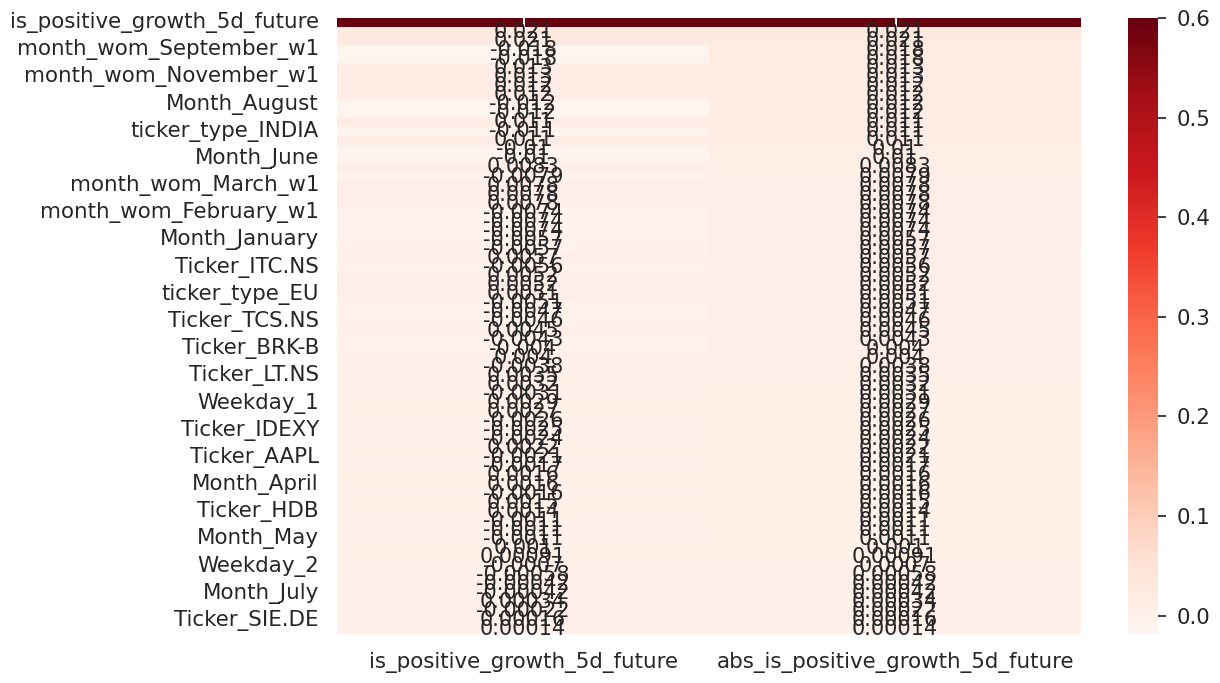

In [ ]:
import seaborn as sns
plt.figure(figsize=(12,8))
sns.set(font_scale=1.4)
sns.heatmap(df_corr_sort,cmap="Reds",annot=True,annot_kws={"size":15},vmax=0.6)
plt.show()


In [ ]:
df_corr_sort.iloc[1, 1]

0.020712738417957552

In [ ]:
df_corr_sort.index[1]

'Month_October'

In [ ]:
f"the most correlated dummy with the binary outcome variable [is_positive_growth_5d_future]: {df_corr_sort.iloc[1, 1]:.4f} and {df_corr_sort.index[1]}"

'the most correlated dummy with the binary outcome variable [is_positive_growth_5d_future]: 0.0207 and Month_October'

### Question 2 (2 points): Define new "hand" rules on macro and technical indicators variables

**What is the precision score for the best of the NEW predictions (pred3 or pred4), rounded to 3 digits after the comma?**

Let's utilize the knowledge from the visualised tree (clf10) (Code Snippet 5: 1.4.4 Visualisation):

* You're asked to define two new 'hand' rules (leading to 'positive' subtrees):
  - `pred3_manual_gdp_fastd`: (gdppot_us_yoy <= 0.027) & (fastd >= 0.251)
  - `pred4_manual_gdp_wti_oil`: (gdppot_us_yoy >= 0.027) & (growth_wti_oil_30d <= 1.005)

* Extend the Code Snippet 3 (Manual "hand rule" predictions): Calculate and add new rules (pred3 and pred4) to the dataframe.You should notice that one of the predictions doesn't have any positive predictions on TEST dataset (while it has many on TRAIN+VALIDATION).

* Debug: check in the `new_df` and the original dataset/data generation process that we didn't make any mistakes during the data transformation step.

* Explain why this can happen even if there are no errors in the data features.

* As a result, write down the precision score for the remaining predictor (round to three decimal points). E.g. if you have 0.57897, your answer should be 0.579.

In [ ]:
derived_feature = "pred3_manual_gdp_fastd"
f"the precision values for feature '{derived_feature}': 0.555 in the test dataset, 0.5459 in the train dataset and 0.5717 in the validation dataset "

"the precision values for feature 'pred3_manual_gdp_fastd': 0.555 in the test dataset, 0.5459 in the train dataset and 0.5717 in the validation dataset "

The feature pred4_manual_gdp_wti_oil is defined by the conditions gdppot_us_yoy >= 0.027 and growth_wti_oil_30d <= 1.005. For this feature to be true in the test split, both conditions must be met. However, in the test dataset, the maximum value for gdppot_us_yoy is 0.022251, which does not meet the gdppot_us_yoy >= 0.027 condition. As a result, the pred4_manual_gdp_wti_oil feature is always false and does not appear in the test dataset.

The same situation occurs in the validation dataset, where the maximum value for gdppot_us_yoy is 0.020894. Since this also does not satisfy the gdppot_us_yoy >= 0.027 condition, the pred4_manual_gdp_wti_oil feature remains false and does not appear in the validation dataset either.

In the train dataset, the maximum value for gdppot_us_yoy is 0.044886. This does satisfy the gdppot_us_yoy >= 0.027 condition and so the pred4_manual_gdp_wti_oil feature is true and therefore it appears in the validation data.

### Question 3 (1 point): Unique correct predictions from a 10-levels deep Decision Tree Classifier (pred5_clf_10)

**What is the total number of records in the TEST dataset when the new prediction pred5_clf_10 is better than all 'hand' rules (pred0..pred4)?**

NOTE: please include `random_state=42` to Decision Tree Classifier init function (line `clf = DecisionTreeClassifier(max_depth=max_depth, random_state=42)`) to ensure everyone gets the same results.

Suggested solution:
* Step1: Rewrite the '1.4.3 Inference for a decision tree' piece for the Decision Tree Classifier with max_depth=10 (clf_10), so that you fit the model on TRAIN+VALIDATION sets (unchanged from the lecture), but predict on the whole set X_all (to be able to define a new column 'pred5_clf_10' in the dataframe new_df). Here is the [link](https://stackoverflow.com/questions/40729162/merging-results-from-model-predict-with-original-pandas-dataframe) with explanation. It will solve the problem in 1.4.5 when predictions were made only for Test dataset and couldn't be easily joined with the full dataset.

* Step2: Once you have it, define a new column 'only_pred5_is_correct' similar to 'hand' prediction rules with several conditions: is_positive_growth_5d_future AND is_correct_pred5 should be equal 1, while all other predictions is_correct_pred0..is_correct_pred4 should be equal to 0.

* Step3: Convert 'only_pred5_is_correct' column from bool to int, and find how many times it is equal to 1 in the TEST set. Write down this as an answer.

ADVANCED: define a function that can be applied to the whole row of predictions ([a few examples of pandas-apply-row-functions](https://sparkbyexamples.com/pandas/pandas-apply-function-to-every-row/)) and can find whether some prediction 'predX' (where X is one of the predictions) is uniquely correct. It should work even if there are 100 predictions available, so that you don't define manually the condition for 'predX'.  
